<a href="https://colab.research.google.com/github/calebchin/DRNN/blob/main/fed_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Federation

## Setup + Load Packages

### For working with git through colab

In [ ]:
%git clone https://github.coecis.cornell.edu/cs4701-24fa-projects/CAP_The-Federation_asj53_ctc92.git

In [4]:
%cd CAP_The-Federation_asj53_ctc92/src

/content/CAP_The-Federation_asj53_ctc92/src


  git config --global user.email "ctc92@cornell.edu"
  
  git config --global user.name "Caleb Chin"

### For demo/normal use

You should `pip install -r requirements.txt`

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import fedisca
import train_loc
from train_loc import LocalTrainer
from resnet import ResNet50, ResNet18
import medmnist
import torchvision.transforms as transforms

## Testing training of single local classifier

We use the entire dataset (in this case pathmnist) to train and validate a single local classifier.

In [4]:
data_flag = 'pathmnist'
download = True

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

100%|██████████| 206M/206M [00:11<00:00, 17.3MB/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [6]:
aug_list = []
aug_list.append(transforms.RandomCrop(28, padding=4))
aug_list.append(transforms.RandomHorizontalFlip())
preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]

In [13]:
loc_trainer_test = LocalTrainer(ResNet18(), DataClass, "./loc_model_weights", n_classes, epochs=2,  aug=aug_list, preprocess=preprocess_list, seed=42)

In [14]:
loc_trainer_test.train()

0.8005577921867371
0.7865528391046248
Epoch num: 1 
Train loss: 3.752994 
Val loss: 0.004420 
Val acc: 0.800558
Val balanced acc: 0.786553
0.8364038467407227
0.8336138098536914
Epoch num: 2 
Train loss: 1.869010 
Val loss: 0.004180 
Val acc: 0.836404
Val balanced acc: 0.833614
All done!


## Testing data partition for federation sims

We test the data partition method `utils.fl_partition' by verifying the splits are visually i.i.d (class balance matches, partition size is equal) when the i.i.d partition is specified and visually non i.i.d when it is not supposed to be.

In [22]:
data_flag = 'pathmnist'
download = True

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(root="./", split='train', download=download)

train_dataset

100%|██████████| 206M/206M [00:12<00:00, 16.3MB/s]


Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: ./
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into trainin

We plot the distribution of labels of the original dataset. We use chatgpt to assist in the coding of this visualization using the prompt:

"Given a list of labels, plot the distribution of the labels using python and matplotlib"

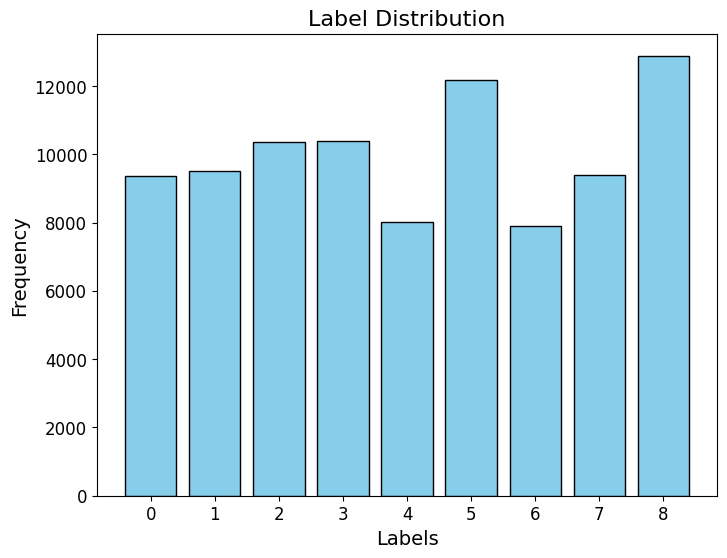

In [23]:
import matplotlib.pyplot as plt
from collections import Counter

# Example list of labels
labels = train_dataset.labels.flatten().tolist()

# Count the frequency of each label
label_counts = Counter(labels)

# Extract labels and their counts
categories = list(label_counts.keys())
counts = list(label_counts.values())

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Label Distribution', fontsize=16)
plt.xticks(ticks = categories, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

Next, we test an i.i.d partition into 5 datasets and check if each of them display a similar distribution over the labels.

In [31]:
import utils
import numpy as np

In [64]:
part_dir, list_name, split_ids = utils.fl_partition(train_dataset, 5, 10, seed=42)

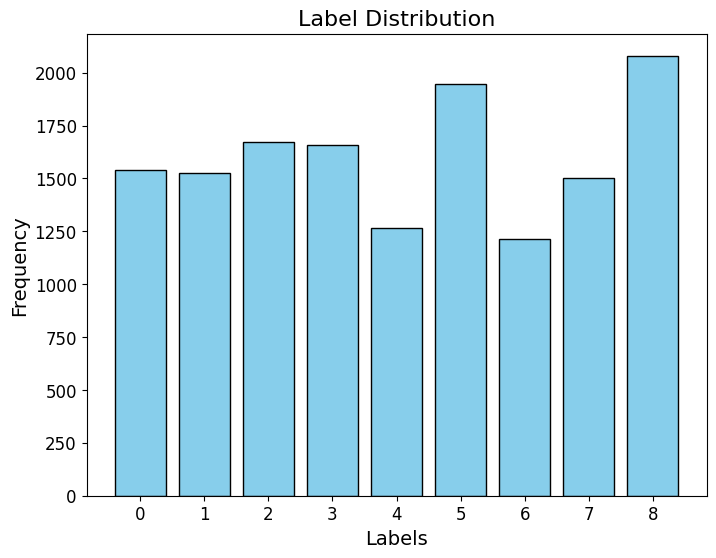

In [66]:
list_ind = 0
f_name = list_name[list_ind]
data = np.load(f_name)
labels = data['train_labels'].flatten().tolist()
label_counts = Counter(labels)
categories = list(label_counts.keys())
counts = list(label_counts.values())

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Label Distribution', fontsize=16)
plt.xticks(ticks = categories, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

Next, we want to make sure the dirichlet non-i.i.d splits are visually heterogenous.

In [68]:
part_dir, list_name, split_ids = utils.fl_partition(train_dataset, 5, 10, iid=False, min_size=1000, seed=42)

[[50227, 44603, 20714, 3512, 86902, 43812, 34919, 69460, 19219, 35809, 61260, 7263, 59995, 38576, 15817, 36044, 81249, 29192, 5926, 53303, 37582, 45026, 30327, 52736, 82166, 57519, 36461, 27644, 27048, 69581, 34904, 38788, 83248, 31241, 26462, 13819, 6255, 35184, 73703, 29681, 69470, 20493, 89088, 70173, 79863, 50958, 24128, 68866, 64209, 57812, 88212, 37991, 76063, 22883, 60192, 10350, 85222, 28147, 57393, 33628, 46524, 75279, 79797, 2075, 10018, 52033, 1373, 88900, 60110, 40396, 5588, 59017, 50157, 57382, 52668, 49968, 38728, 6168, 16120, 57360, 26224, 12317, 48600, 79232, 24923, 11925, 47744, 39687, 76284, 6887, 67772, 79848, 40002, 79708, 76049, 12484, 25077, 77912, 84255, 20064, 3707, 25833, 50978, 77838, 26342, 2439, 33138, 38944, 71254, 31953, 52284, 81771, 89636, 25631, 87595, 59472, 39964, 16276, 33436, 80481, 26608, 4685, 69627, 39940, 87815, 50899, 9440, 66920, 61324, 1037, 43615, 26627, 57384, 5630, 85095, 29233, 79873, 51911, 44652, 80035, 49596, 45609, 41543, 40574, 57367

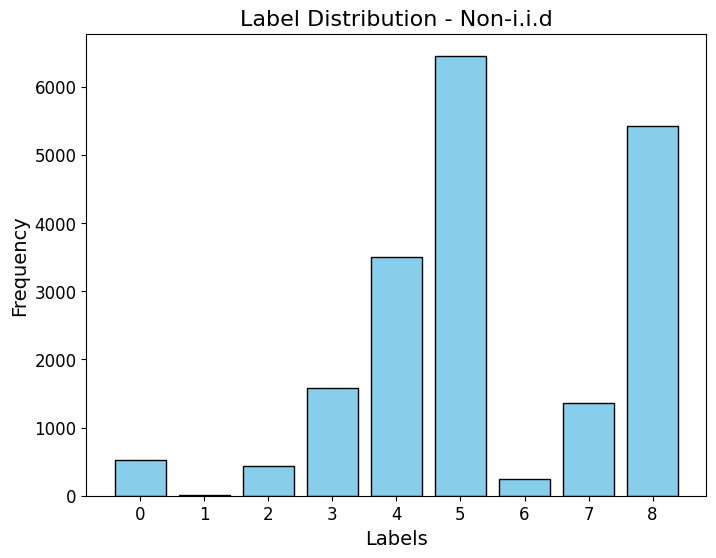

In [69]:
list_ind = 0
f_name = list_name[list_ind]
data = np.load(f_name)
labels = data['train_labels'].flatten().tolist()
label_counts = Counter(labels)
categories = list(label_counts.keys())
counts = list(label_counts.values())

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Label Distribution - Non-i.i.d', fontsize=16)
plt.xticks(ticks = categories, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()